In [2]:
import numpy as np
from spiker import *
import matplotlib.pyplot as plt
from rnn import rnn

Sequence length is 2000000


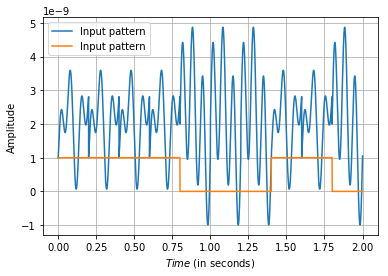

In [3]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time
# Some input
ip,op,tsteps = gen_data(nblocks=10, f1=4, f2=15, tstop=2)

inp = Tseries(ip, tsteps)
inp.plot(label = "Input pattern")
out = Tseries(op, tsteps)
out.plot(label = "Input pattern")

ip.shape = (1,ip.shape[0])
op.shape = (1,op.shape[0])
print('Sequence length is {}'.format(ip.shape[1]))

In [4]:
def set_all_weights_to_one(net):
    for idx in range(len(net.weights)):
        net.weights[idx] = np.ones_like(net.weights[idx])*1e-2

In [5]:
# Test case
ip_dim = ip.shape[0]
op_dim = op.shape[0]
res_dim = 51
nrlayers = 4
seq_len = ip.shape[1]

net = rnn(nrlayers, ip_dim, res_dim, op_dim)
# set_all_weights_to_one(net)
ann_states = net.rnn_forward(ip, mode='ann')
snn_states = net.rnn_forward(ip, mode='snn')

In [6]:
new_W = net.train_last_layer(op, ann_states[-2])

In [ ]:
plt.rcParams['lines.linewidth'] = 1.2
import matplotlib.patches as mpatches
# Plotting and visualization
print('Pole frequency = {0:.3f} Hz'.format(1/net.tau))
for idx in range(len(ann_states)): # layer idx
    dims = ann_states[idx].shape[0]
    if dims >= 3:
        cols = 3
    else:
        cols=dims
    rows = int(np.ceil(dims/cols))
    fig, axs = plt.subplots(rows,cols)
    if idx == 0:
        fig.suptitle(f'Input feed-forward layer', fontsize=12)
    elif idx == len(ann_states)-1:
        fig.suptitle(f'Output feed-forward layer', fontsize=12)
    elif idx%2 == 1:
        fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}', fontsize=12)
    else:
        fig.suptitle(f'Feed-forward layer {int(np.floor((idx)/2))}', fontsize=12)
    for jdx in range(ann_states[idx].shape[0]): # dim idx
        ax = plt.subplot(rows,cols,jdx+1)
        plt.plot(tsteps, ann_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
        plt.plot(tsteps, snn_states[idx][jdx,:], color='g', alpha=0.7, label=f'SNN - Layer {idx}')
        plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
    patch1 = mpatches.Patch(color='g', label='ANN output')
    patch2 = mpatches.Patch(color='r', label='SNN output')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.legend(handles=[patch1, patch2], loc='lower center', fancybox=True, shadow=True, fontsize=12, ncol=2)
    plt.savefig(f'./img/ANN-RNN-Layer-{idx}.png', dpi=300)
t = 0
for N in net.neurons:
    t += np.sum(N.spike_count)
print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))